In [5]:
!pip install sentinelhub

In [1]:
# Utilities
import matplotlib.pyplot as plt
import pandas as pd
import getpass

from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubCatalog,
    SentinelHubRequest,
    SentinelHubStatistical,
    BBox,
    bbox_to_dimensions,
    CRS,
    MimeType,
    Geometry,
)

from utils import plot_image

In [ ]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
config.sh_client_id = getpass.getpass("sh-fe913274-f231-4fba-b8f7-2a5d668e178e")
config.sh_client_secret = getpass.getpass("ALuP8cxWven92rhxm8DUSUO2SmJZGHMl")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.save("cdse")

In [ ]:
# config = SHConfig("cdse")

In [4]:
aoi_coords_wgs84 = [15.461282, 46.757161, 15.574922, 46.851514]

In [5]:
resolution = 10
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
aoi_size = bbox_to_dimensions(aoi_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {aoi_size} pixels")

Image shape at 10 m resolution: (860, 1054) pixels


In [6]:
catalog = SentinelHubCatalog(config=config)

In [12]:
aoi_bbox = BBox(bbox=aoi_coords_wgs84, crs=CRS.WGS84)
time_interval = "2022-07-01", "2022-07-20"

search_iterator = catalog.search(
    DataCollection.SENTINEL2_L2A,
    bbox=aoi_bbox,
    time=time_interval,
    fields={"include": ["id", "properties.datetime"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

results

Total number of results: 8


[{'id': 'S2B_MSIL2A_20220719T095559_N0510_R122_T33TWM_20240717T224534.SAFE',
  'properties': {'datetime': '2022-07-19T10:07:52.974Z'}},
 {'id': 'S2B_MSIL2A_20220716T094549_N0510_R079_T33TWM_20240709T130554.SAFE',
  'properties': {'datetime': '2022-07-16T09:57:56.446Z'}},
 {'id': 'S2A_MSIL2A_20220714T100041_N0510_R122_T33TWM_20240703T133330.SAFE',
  'properties': {'datetime': '2022-07-14T10:08:00.663Z'}},
 {'id': 'S2A_MSIL2A_20220711T095041_N0510_R079_T33TWM_20240703T225755.SAFE',
  'properties': {'datetime': '2022-07-11T09:58:04.716Z'}},
 {'id': 'S2B_MSIL2A_20220709T100029_N0510_R122_T33TWM_20240723T171717.SAFE',
  'properties': {'datetime': '2022-07-09T10:07:52.887Z'}},
 {'id': 'S2B_MSIL2A_20220706T095039_N0510_R079_T33TWM_20240701T011914.SAFE',
  'properties': {'datetime': '2022-07-06T09:57:56.879Z'}},
 {'id': 'S2A_MSIL2A_20220704T100041_N0510_R122_T33TWM_20240622T180348.SAFE',
  'properties': {'datetime': '2022-07-04T10:08:01.165Z'}},
 {'id': 'S2A_MSIL2A_20220701T095041_N0510_R079_T

In [14]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A.define_from(
                name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
            ),
            time_interval=("2022-05-01", "2022-05-20"),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}},
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=aoi_bbox,
    size=aoi_size,
    config=config,
)

In [15]:
true_color_imgs = request_true_color.get_data()

In [16]:
print(
    f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}."
)
print(
    f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}"
)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (1054, 860, 3)


Image type: uint8


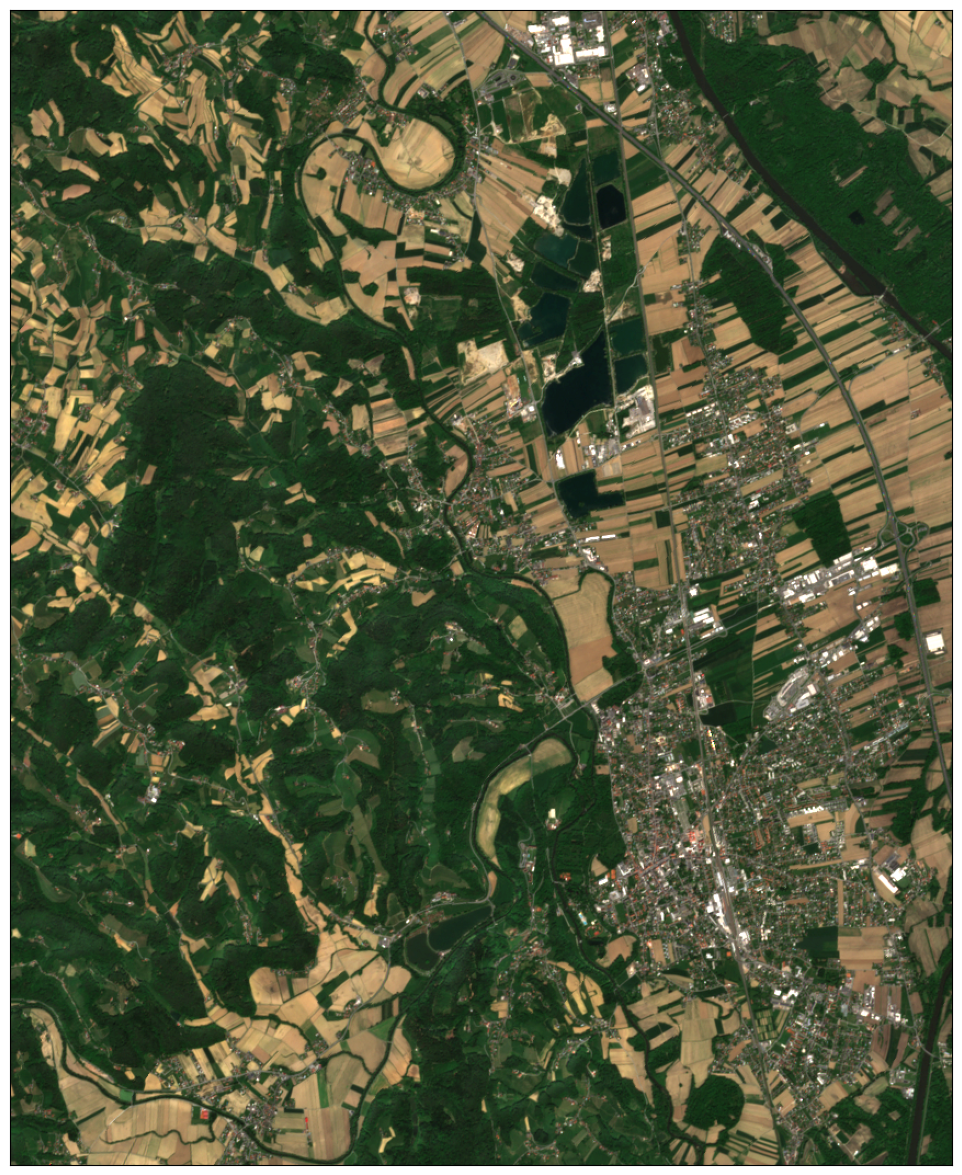

In [17]:
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=3.5 / 255, clip_range=(0, 1))